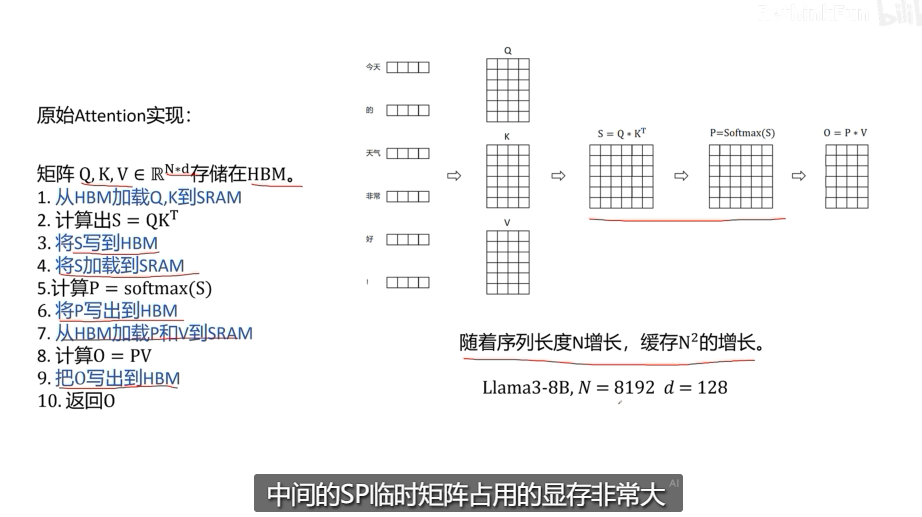
主要是中间结果S很大，还在HBM和SRAM之间移动，影响计算效率和内存节约

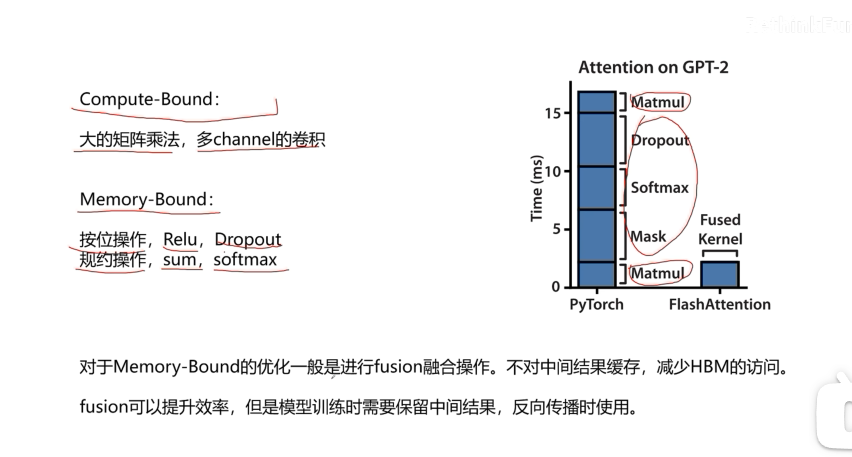
计算约束一般是矩阵乘法

内存约束一般是RELU、dropout sum softmax等 attention一般是内存约束




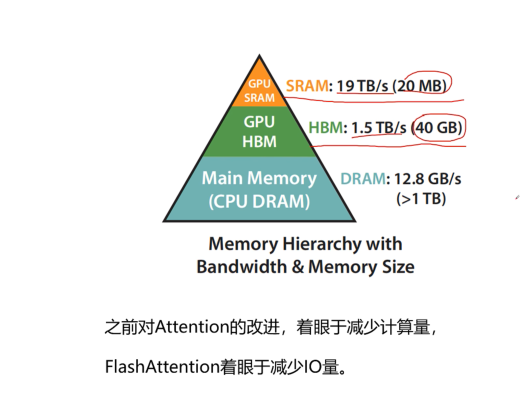

HBM容量大访问慢，SRAM容量小访问快。HBM用来存储中间变量，SRAM用来计算。

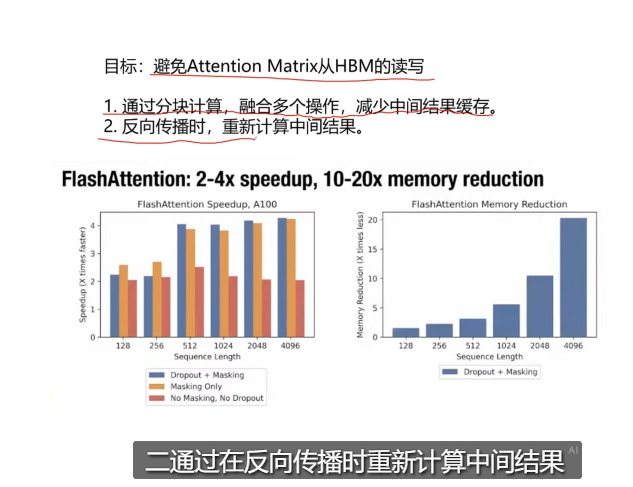

速度2-4倍，平方内存变成线性内存

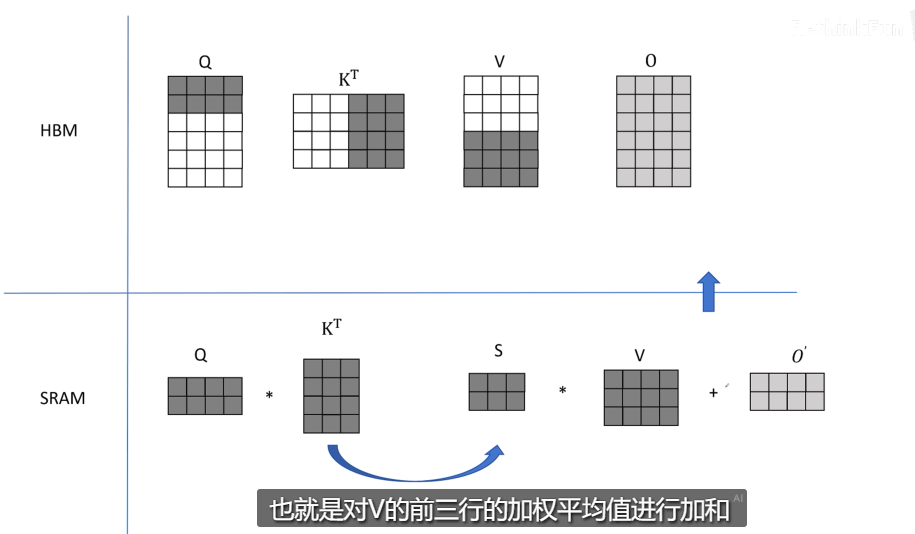

分块以后每次都计算一部分的O值浅色（所有分块的累加才是最终O值深色）

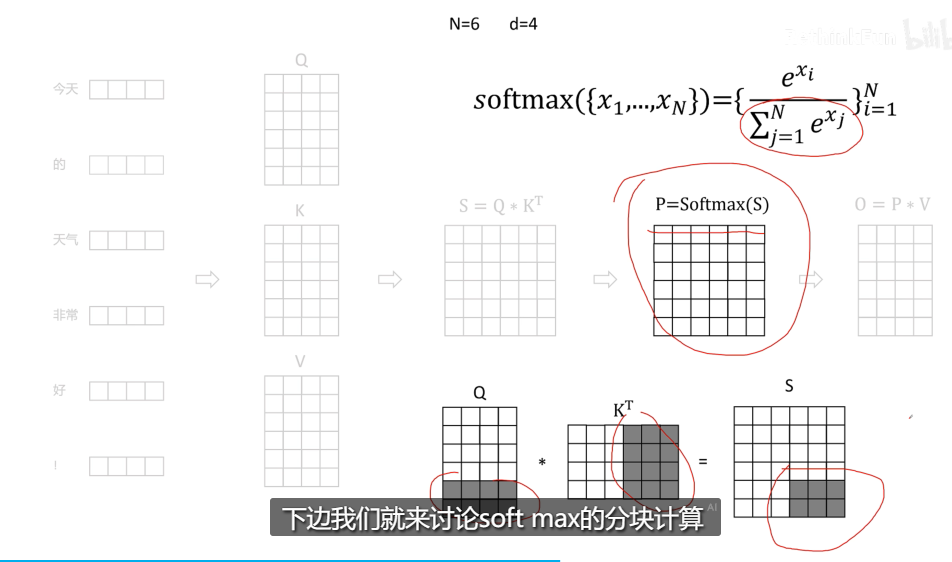

注意softmax是横向的，S是横向的一部分，所以要分段


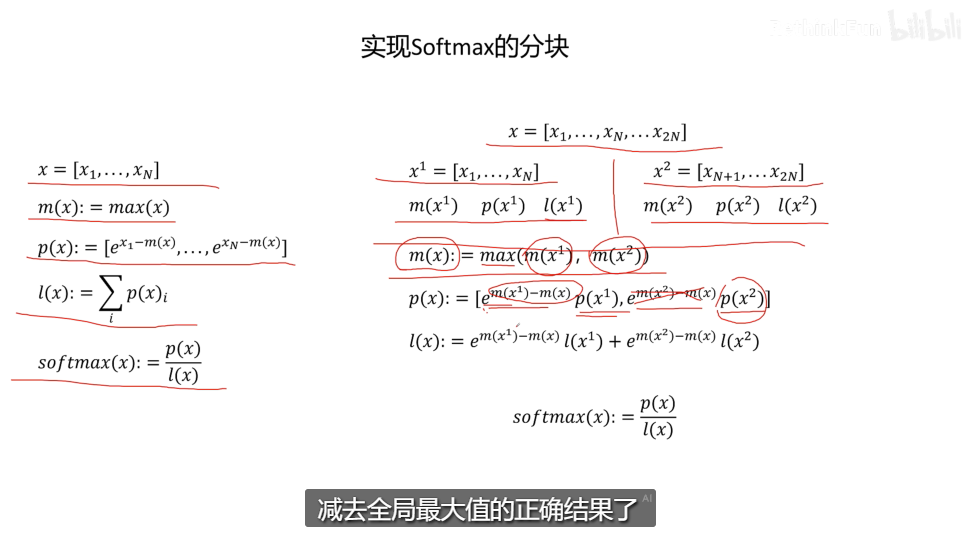
注意这里是分成了2块，实际上分成n块都可以，m(x) = max(m1(x)  m2(x)....)

每一个小区间是减去了这个区间里的最大值（局部最大），实际上的softmax是全局最大，所以对应的乘以e^(m1(x)-m(x))

其中m(x)和l(x)需要存到HBM（但对于S这种大的矩阵，赚太多）

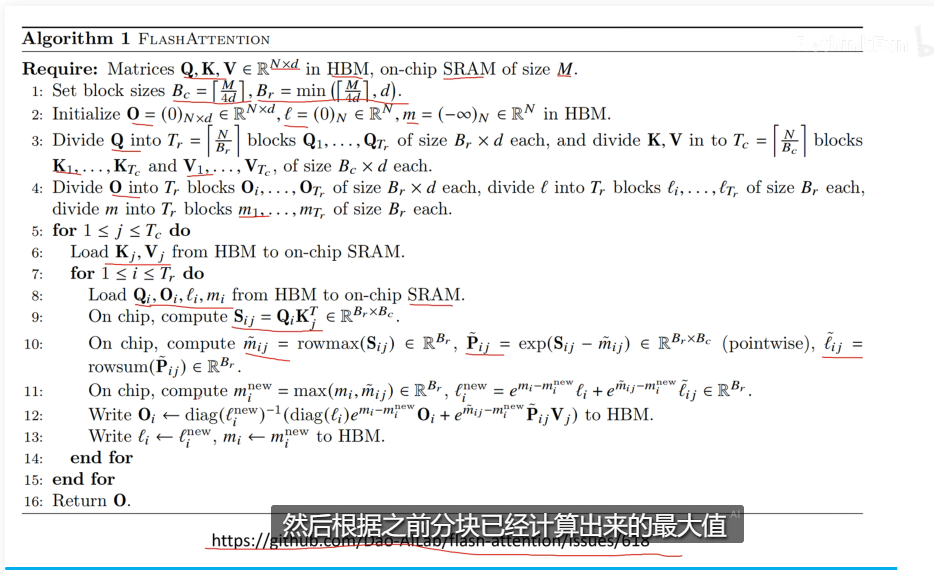

1. 传统注意力机制的瓶颈

传统自注意力计算需生成中间矩阵 S（QKᵀ） 和 P（Softmax结果），内存占用为 O(N²)（N为序列长度）。例如，当序列长度 N=32,000 时，中间矩阵占用约 4GB 显存。这导致：

内存爆炸：长序列场景下显存不足，限制模型扩展性。
计算低效：频繁访问高带宽内存（HBM）引发 I/O 瓶颈，GPU 计算单元因等待数据而闲置。

2. FlashAttention 的核心优化

（1）分块计算（Tiling）与核函数融合
分块策略：将输入矩阵 Q、K、V 切分为小块（Tiles），每次仅加载一个块到高速缓存（SRAM）中进行局部计算，避免一次性加载整个矩阵。SRAM的存储空间小，所以需要分页

在线 Softmax：通过分块累加计算 Softmax 的统计量（如最大值、求和项），无需存储中间矩阵。

算子融合：将 QKᵀ、Softmax、加权求和等步骤合并为单一核函数（Kernel），减少 HBM 访问次数。

（2）内存访问优化
HBM → SRAM 数据传输：利用 GPU 的 SRAM（速度达 19TB/s）暂存中间结果，减少对 HBM（速度约 1.5TB/s,对比sram太低了，移来移去太慢了，所以要减少HBM的调用）的依赖。
内存复杂度降至 O(N)：仅需存储最终输出矩阵，显存占用与序列长度成线性关系。

（3）并行化与任务调度优化
内外循环交换：在 FlashAttention v2 中，外循环遍历 K/V，内循环遍历 Q，减少共享内存读写与线程同步开销。
Warp 级任务划分：优化 GPU 线程块的负载均衡，提升并行计算效率。

# 反向传播

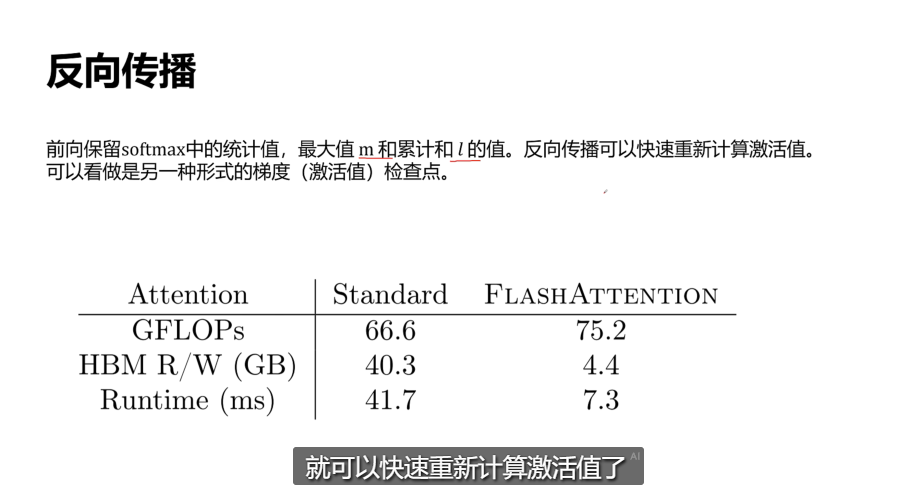

m和l可以作为梯度检查点


flashattention V2
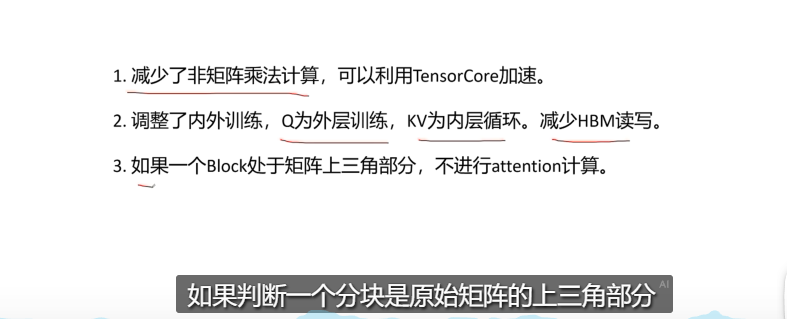

